In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sys.path.append('..')
import datetime as DT
import os
import rbf_functions

In [4]:
rbfs = [rbf_functions.original_rbf,
        rbf_functions.squared_exponential_rbf,
        rbf_functions.inverse_quadratic_rbf,
        rbf_functions.inverse_multiquadric_rbf,
        rbf_functions.exponential_rbf,
        rbf_functions.matern32_rbf,
        rbf_functions.matern52_rbf,
       ]

nfearchive = {}
for n in rbfs:
    nfearchive[n.__name__] = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = f"../output/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
            selected_nfe = u_nfes[0::5]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

In [18]:
from platypus import Solution, Problem, GenerationalDistance

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
seeds = np.arange(10, 101, 10).tolist()
for n in rbfs:
    archives[n.__name__] = {}
    for i in seeds:
        archives[n.__name__][i] = {}
for entry in rbfs:
    name = entry.__name__
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive
        

In [16]:
# load refsets for each rbf
# ref_dir = "../refsets/"
# ref_sets = {}
# for n in rbfs:
#     name = n.__name__
#     ref_sets[name] = {}
#     data = pd.read_csv(f'{ref_dir}{name}_refset.csv')  
#     ref_set = []
#     for i, row in data.iterrows():
#         solution = Solution(problem)
#         solution.objectives = row
#         ref_set.append(solution)
#     ref_sets[name] = ref_set

# load refset for all rbfs
ref_dir = "./refsets/"
ref_sets = {}
data = pd.read_csv(f'{ref_dir}all_rbf_refset.csv')  
ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)

In [17]:
ref_set

[Solution[None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None|70.79821768306873,0.5912793865645635,0.6117357165968234,0.7744670112796567,0.0819427975437735,1.0|0.0],
 Solution[None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None|59.00586899039647,0.7965876192104864,0.5867428912378385,0.8862109212578678,0.0763627297243822,1.0|0.0],
 Solution[None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None|54.74422577767099,0.6856672465703326,0.4196573334930386,0.8088564997175268,0.0419767847852911,0.9285714285714286|0.0],
 Solution[None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

In [20]:
# gd = GenerationalDistance(reference_set=ref_set)
# nfes = []
# gds = []
# for nfe, archive in archives.items():
#     nfes.append(nfe)
#     gds.append(gd.calculate(archive))
    
tempnfe = {}
tempgd = {}
nfe_sets = {}
gd_sets = {}
for rbf in archives:
    nfe_sets[rbf] = {}
    gd_sets[rbf] = {}
    gd = GenerationalDistance(reference_set=ref_sets[rbf])
    print(f"started {rbf} at {DT.datetime.now()}")
    for seed in archives[rbf]:
        nfe_sets[rbf][seed] = {}
        gd_sets[rbf][seed] = {}
        s_archives = archives[rbf][seed]
        nfes = []
        gds = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            gds.append(gd.calculate(archive))
        nfe_sets[rbf][seed] = nfes
        gd_sets[rbf][seed] = gds
        tempnfe[seed] = nfes
        tempgd[seed] = gds
        dfgd = pd.DataFrame.from_dict(tempgd, orient='index')
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
        dfgd = dfgd.T
        dfnfe = dfnfe.T
        dfgd.to_csv(f"gd_all/{rbf}_gd.csv", index=False)
        dfnfe.to_csv(f"gd_all/{rbf}_gd_nfe.csv", index=False)
        print(f"finished seed: {seed} at {DT.datetime.now()}")

started original_rbf at 2022-01-08 01:14:47.278321
finished seed: 10 at 2022-01-08 01:15:57.130023
finished seed: 20 at 2022-01-08 01:17:04.068607
finished seed: 30 at 2022-01-08 01:18:35.695661
finished seed: 40 at 2022-01-08 01:20:07.134189
finished seed: 50 at 2022-01-08 01:21:15.565245
finished seed: 60 at 2022-01-08 01:22:38.439407
finished seed: 70 at 2022-01-08 01:23:48.493694
finished seed: 80 at 2022-01-08 01:24:48.342596
finished seed: 90 at 2022-01-08 01:26:04.894530
finished seed: 100 at 2022-01-08 01:27:29.983930
started squared_exponential_rbf at 2022-01-08 01:27:30.027812
finished seed: 10 at 2022-01-08 01:28:16.850359
finished seed: 20 at 2022-01-08 01:29:25.812546
finished seed: 30 at 2022-01-08 01:30:00.749639
finished seed: 40 at 2022-01-08 01:30:53.680396
finished seed: 50 at 2022-01-08 01:31:46.594777
finished seed: 60 at 2022-01-08 01:32:49.450219
finished seed: 70 at 2022-01-08 01:34:04.850675
finished seed: 80 at 2022-01-08 01:34:53.936143
finished seed: 90 at 2

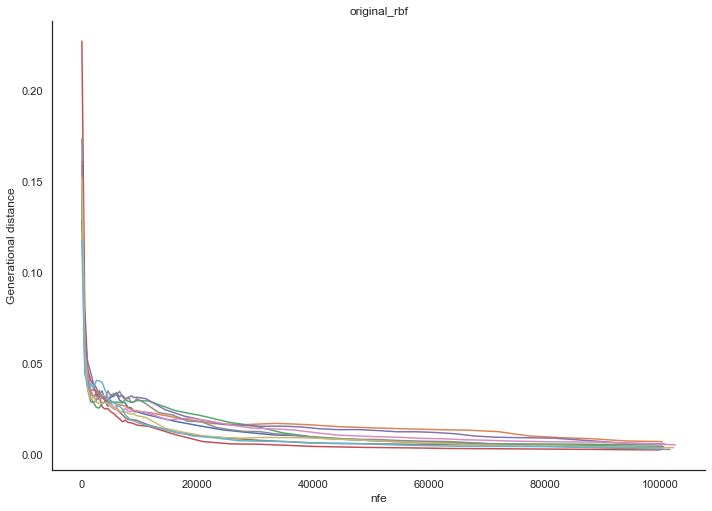

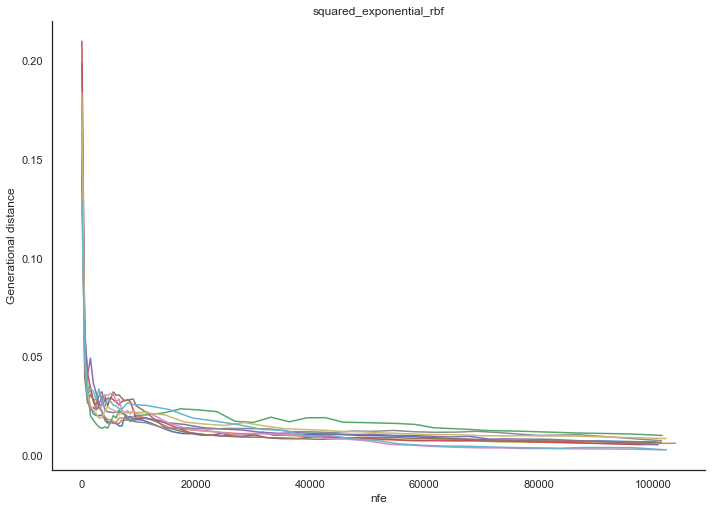

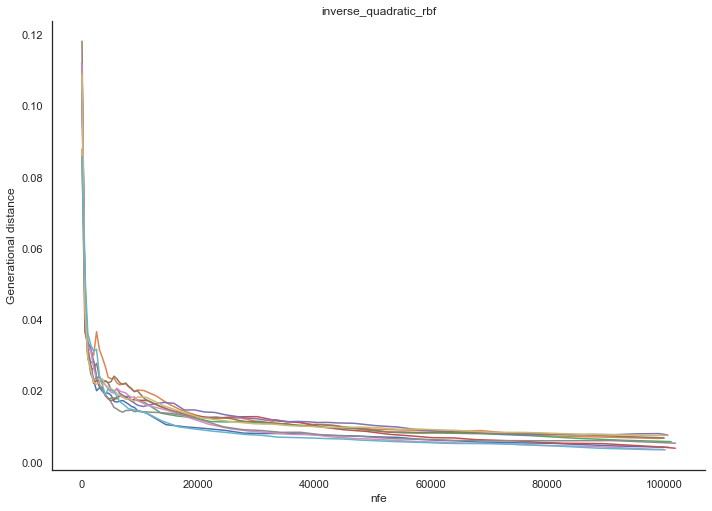

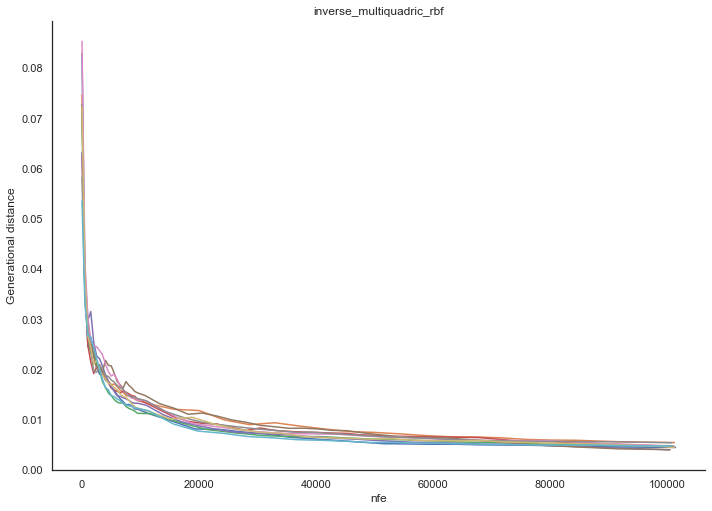

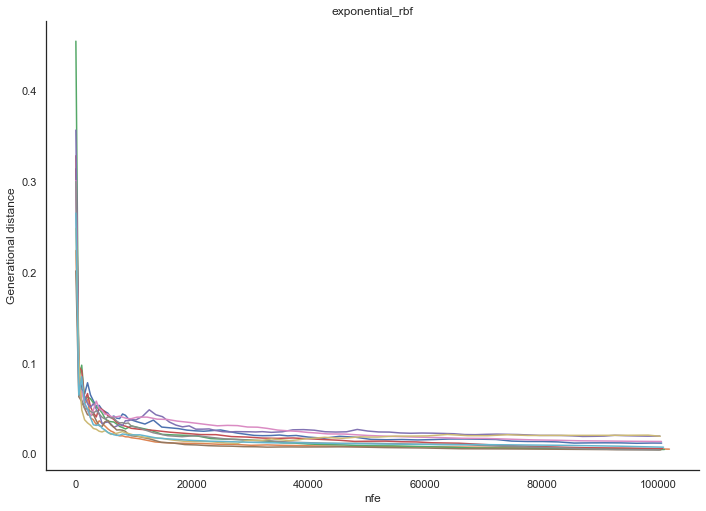

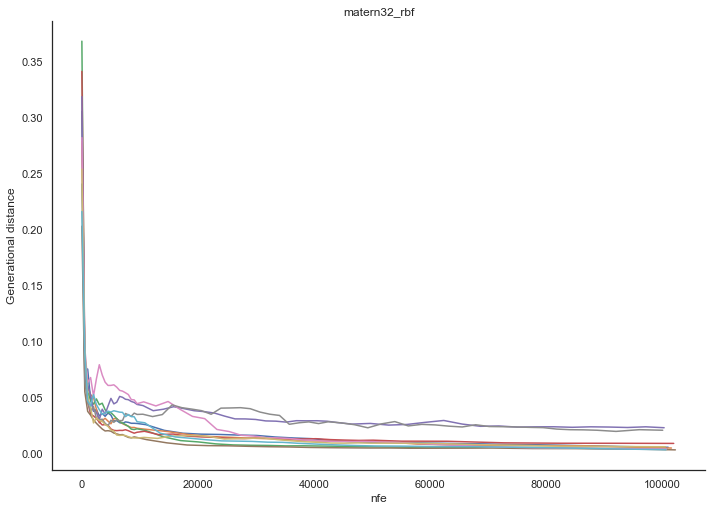

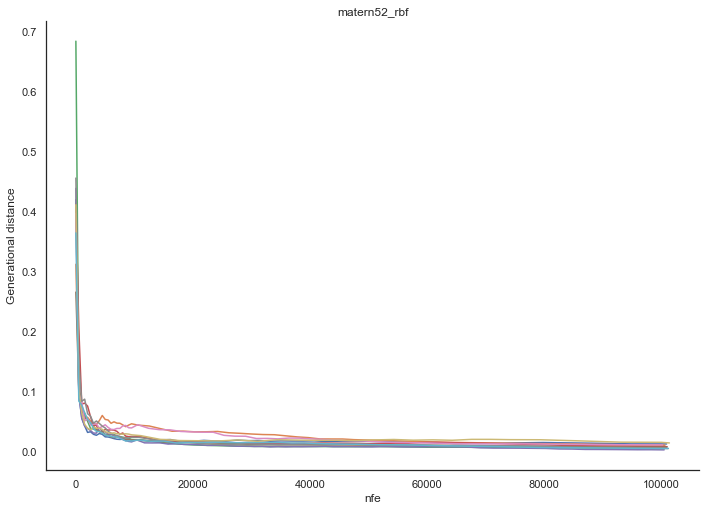

In [21]:
sns.set_style("white")
for entry in rbfs:
    name = entry.__name__
    gd = pd.DataFrame.from_dict(gd_sets[name], orient='index').T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient='index').T
    
    fig, ax = plt.subplots()
    ax.plot(nfe, gd)
    ax.set_xlabel('nfe')
    ax.set_ylabel('Generational distance')
    ax.set_title(name)
    sns.despine()

    plt.show()

In [12]:
from platypus import InvertedGenerationalDistance

igd = InvertedGenerationalDistance(reference_set=ref_set)
nfes = []
igds = []
for nfe, archive in archives.items():
    nfes.append(nfe)
    igds.append(igd.calculate(archive))

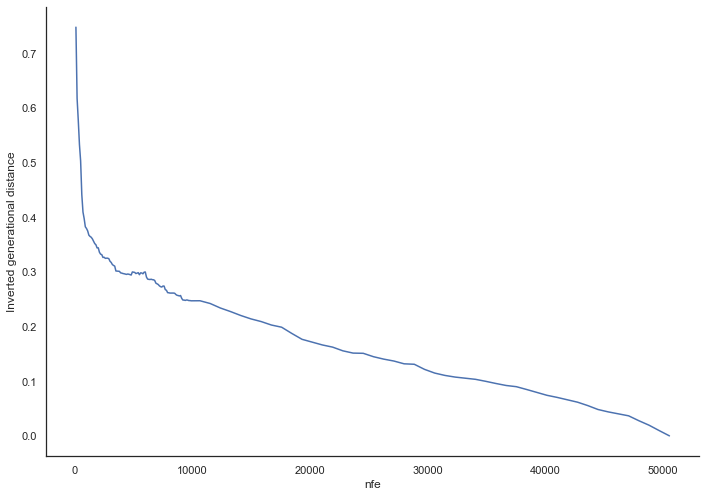

In [14]:
sns.set_style("white")

fig, ax = plt.subplots()

ax.plot(nfes, igds)
ax.set_xlabel('nfe')
ax.set_ylabel('Inverted generational distance')
sns.despine()

plt.show()